# **Detección de Fraude**

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, confusion_matrix, classification_report, ConfusionMatrixDisplay
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Datos Originales**

In [0]:
# ruta de la tabla en DBFS
dbfs_table_path = "default.ps_20174392719_1491204439457_log"

# Lee los datos desde la tabla en DBFS y crea un DataFrame de Pandas
data = spark.sql('''  select * from ps_20174392719_1491204439457_log ''')
datos = data.toPandas()

**Teniendo en cuenta el análisis anterior, solo se tendrá en cuenta los tipos de transacciones: TRANSFER y CASH_OUT**

In [0]:
X = datos.loc[(datos.type == 'TRANSFER') | (datos.type == 'CASH_OUT')]

**Eliminamos las variables que consideramos que son menos significativas**

In [0]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [0]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) 

In [0]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.00,0.0,0.00,0.00,1
3,1,1,181.00,181.00,0.0,21182.00,0.00,1
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,0,215310.30,705.00,0.0,22425.00,0.00,0
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00,1


In [0]:
X["isFraud"].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

# **Aplicación de modelos**

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Separación de los conjuntos de prueba y entrenamiento - Escalado

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(['isFraud'], axis = 1), X['isFraud'],
                                                    random_state=0, test_size=0.3, stratify=X['isFraud'])

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

## **Primer modelo: Regresión logística**

In [0]:
skf = StratifiedKFold(n_splits=3) ## StratifiedKFold es una variante de KFold que devuelve pliegues estratificados. Los pliegues se hacen preservando el porcentaje de muestras para cada clase.

In [0]:
clf = LogisticRegression(class_weight='balanced')
grid_values = {'penalty': ['l2'],'C':[0.3,0.8,0.9]}
grid_clf = GridSearchCV(clf, param_grid = grid_values, cv=skf, scoring = 'recall')

In [0]:
grid_clf.fit(X_train_n, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.3, 0.8, 0.9], 'penalty': ['l2']},
             scoring='recall')

In [0]:
model = grid_clf.best_estimator_
model

LogisticRegression(C=0.8, class_weight='balanced')

In [0]:
scores = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="precision")
scores

array([0.04331374, 0.0422888 , 0.04304324])

In [0]:
scores1 = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="recall")
scores1

array([0.89613779, 0.88941054, 0.90709812])

In [0]:
scores2 = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="accuracy")
scores2

array([0.94102523, 0.93993927, 0.93995   ])

In [0]:
 pred = model.predict(X_test_n)
 print(confusion_matrix(y_test, pred))

[[781511  47148]
 [   283   2181]]


##### Uno de los elementos interesantes analizados en la regresión logística es que la matriz de confusion con el accuracy balanceado y desbalanceado ofrece resultados similares: Accuracy test = 0.9429314313284556 y Balanced Accuracy test = 0.9141246793363986

Accuracy test = 0.9429314313284556


/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Text(0.5, 1.0, 'Hallazgos')

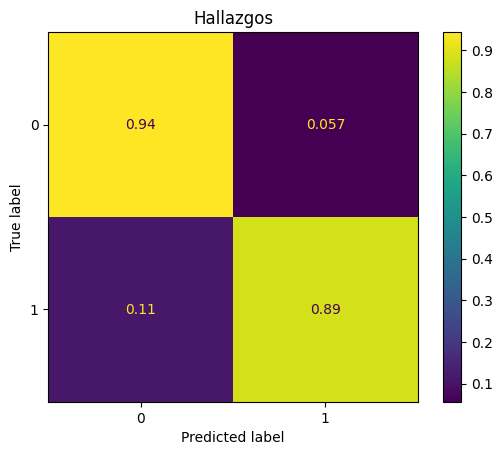

In [0]:
acccuracySinBalanceo = accuracy_score(y_test,model.predict(X_test_n))
print('Accuracy test = '+str(acccuracySinBalanceo))

disp = plot_confusion_matrix(model,X_test_n, y_test,normalize='true')
disp.ax_.set_title('Hallazgos')

In [0]:
acccuracyBalanceado = balanced_accuracy_score(y_test,model.predict(X_test_n))
print('Balanced Accuracy test = '+str(acccuracyBalanceado))


Balanced Accuracy test = 0.9141246793363986


In [0]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828659
           1       0.04      0.89      0.08      2464

    accuracy                           0.94    831123
   macro avg       0.52      0.91      0.53    831123
weighted avg       1.00      0.94      0.97    831123



In [0]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

# Calcular las tasas de verdaderos y falsos positivos
y_score = model.predict_proba(X_test_n)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

# Crear la figura
fig = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
])

# Mostrar la figura
fig.show()


In [0]:
# Calcular las tasas de verdaderos y falsos positivos
y_score = model.predict_proba(X_train_n)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_score)

# Crear la figura
fig = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
])

# Mostrar la figura
fig.show()

In [0]:
f1_score(y_test, pred, average=None)

array([0.97054804, 0.08421988])

In [0]:
import shap

# Crear un objeto explainer SHAP
explainer = shap.TreeExplainer(model)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test)

# Crear un gráfico de resumen SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")


---------------------------------------------------------------------------
InvalidModelError                         Traceback (most recent call last)
File <command-197897160136294>, line 4
      1 import shap
      3 # Crear un objeto explainer SHAP
----> 4 explainer = shap.TreeExplainer(model)
      6 # Calcular los valores SHAP
      7 shap_values = explainer.shap_values(X_test)

File /databricks/python/lib/python3.10/site-packages/shap/explainers/_tree.py:149, in Tree.__init__(self, model, data, model_output, feature_perturbation, feature_names, approximate, **deprecated_options)
    147 self.feature_perturbation = feature_perturbation
    148 self.expected_value = None
--> 149 self.model = TreeEnsemble(model, self.data, self.data_missing, model_output)
    150 self.model_output = model_output
    151 #self.model_output = self.model.model_output # this allows the TreeEnsemble to translate model outputs types by how it loads the model

File /databricks/python/lib/python3.10/site-pa

## **Segundo modelo: Clasificador Random Forest**

In [0]:
st = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #StratifiedShuffleSplit es útil cuando se hacen divisiones aleatorias estratificadas

In [0]:
B=[5, 10, 15]
grid_values1 = {'n_estimators': B, 'max_depth':[3, 4]}

clf1 = RandomForestClassifier(random_state=0, class_weight='balanced_subsample', n_jobs=-1)
grid_clf1 = GridSearchCV(estimator=clf1, param_grid = grid_values1, cv=st, scoring='balanced_accuracy',return_train_score=True)
grid_clf1.fit(X_train_n, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_jobs=-1, random_state=0),
             param_grid={'max_depth': [3, 4], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='balanced_accuracy')

In [0]:
modelo2 = grid_clf1.best_estimator_
modelo2

RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                       n_estimators=15, n_jobs=-1, random_state=0)

In [0]:
 pred1 = modelo2.predict(X_test_n)
 print(confusion_matrix(y_test, pred1))

[[827527   1132]
 [  1507    957]]


In [0]:
scores3 = cross_val_score(modelo2, X_train_n, y_train, cv=skf, scoring="accuracy")
scores3

array([0.96686102, 0.96567914, 0.95124747])

In [0]:
scores4 = cross_val_score(modelo2, X_train_n, y_train, cv=skf, scoring="recall")
scores4

array([0.91440501, 0.92905582, 0.9493737 ])

Accuracy test = 0.9968247780412767


/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Text(0.5, 1.0, 'Hallazgos')

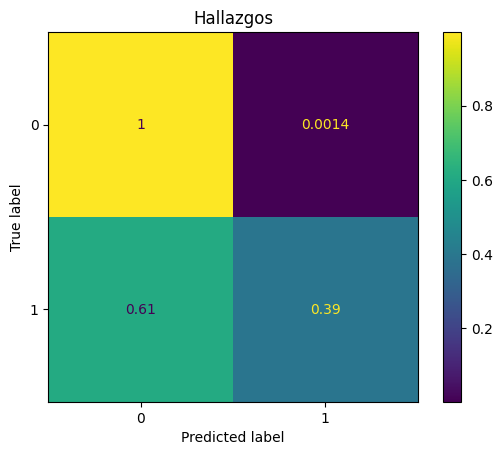

In [0]:
acccuracySinBalanceo = accuracy_score(y_test,modelo2.predict(X_test_n))
print('Accuracy test = '+str(acccuracySinBalanceo))

disp = plot_confusion_matrix(modelo2,X_test_n, y_test,normalize='true')
disp.ax_.set_title('Hallazgos')

Balanced Accuracy test búsqueda = 0.693513397312491


/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Text(0.5, 1.0, 'Búsqueda')

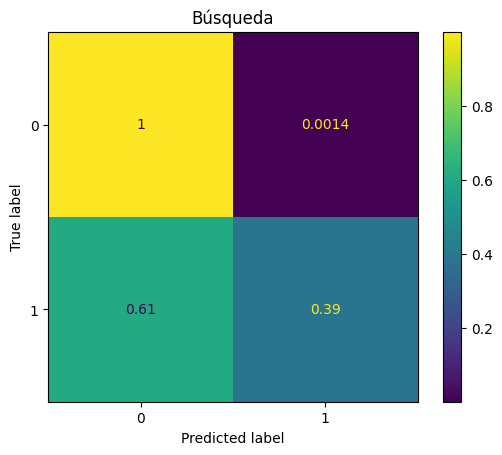

In [0]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test, modelo2.predict(X_test_n))))

disp = plot_confusion_matrix(modelo2, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Hallazgos')

In [0]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.46      0.39      0.42      2464

    accuracy                           1.00    831123
   macro avg       0.73      0.69      0.71    831123
weighted avg       1.00      1.00      1.00    831123



In [0]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

# Calcular las tasas de verdaderos y falsos positivos
y_score = modelo2.predict_proba(X_test_n)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

# Crear la figura
fig = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
])

# Mostrar la figura
fig.show()

In [0]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

# Calcular las tasas de verdaderos y falsos positivos
y_score = modelo2.predict_proba(X_train_n)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_score)

# Crear la figura
fig = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier')
])

# Mostrar la figura
fig.show()

## **Tercer modelo: Isolation Forest**

In [0]:
st = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #StratifiedShuffleSplit es útil cuando se hacen divisiones aleatorias estratificadas

In [0]:
B=[5, 10, 15]
# Genera la proporción de outliers para utilizar como parámetro en IsolationForest
proportion_outliers = len(X[X['isFraud'] == 1]) / float(len(X[X['isFraud'] == 0]))

grid_values3 = {
    'n_estimators': [50, 100, 200],
    'contamination': [proportion_outliers, 0.02, 0.5], # Se agrega el calculo de proportion_outliers para mejorar la precision de este hiperparametro
    'max_samples': [100, 200],
    'max_features': [0, 0.5, 0.8],
}

clf3 = IsolationForest(random_state=111, verbose=0)
grid_clf3 = GridSearchCV(estimator=clf3, param_grid = grid_values3, cv=st, scoring='balanced_accuracy',return_train_score=True)
grid_clf3.fit(X_train_n, y_train)

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

y_pred contains classes not in y_true

/datab

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             estimator=IsolationForest(random_state=111),
             param_grid={'contamination': [0.0029733588782258754, 0.02, 0.5],
                         'max_features': [0, 0.5, 0.8],
                         'max_samples': [100, 200],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [0]:
modelo3 = grid_clf3.best_estimator_
modelo3

IsolationForest(contamination=0.0029733588782258754, max_features=0.5,
                max_samples=100, n_estimators=50, random_state=111)

In [0]:
pred3 = modelo3.predict(X_test_n)
pred3[pred3 == 1] = 0
pred3[pred3 == -1] = 1

In [0]:
 print(confusion_matrix(y_test, pred3))

[[826077   2582]
 [  2405     59]]


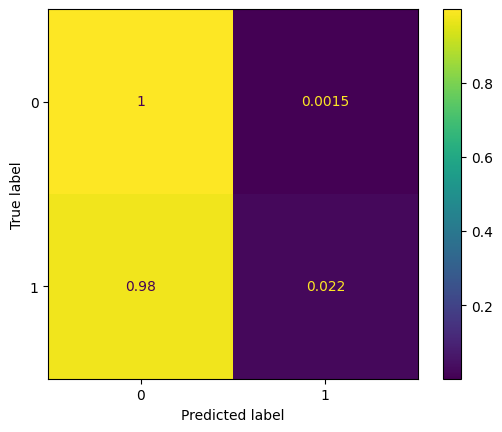

In [0]:
cm = confusion_matrix(y_test, pred3, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [0]:
acccuracySinBalanceo = accuracy_score(y_test,pred3)
print('Accuracy test = '+str(acccuracySinBalanceo))


Accuracy test = 0.9939996847638677


In [0]:
AcucuracyBalanceado = balanced_accuracy_score(y_test, pred3)
print('Balanced Accuracy test búsqueda = '+str(AcucuracyBalanceado))


Balanced Accuracy test búsqueda = 0.5104144638071403


In [0]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.02      0.02      0.02      2464

    accuracy                           0.99    831123
   macro avg       0.51      0.51      0.51    831123
weighted avg       0.99      0.99      0.99    831123



### Modelo 4, Isolation forest con balanceo de datos 

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import SMOTE

In [0]:
smt = SMOTETomek(random_state=42)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train_n, y_train)

In [0]:
from collections import Counter
print("Antes de SMOTE: ", Counter(y_train))
print("Despues de SMOTE: ", Counter(y_train_SMOTE))

Antes de SMOTE:  Counter({0: 1933537, 1: 5749})
Despues de SMOTE:  Counter({0: 1933401, 1: 1933401})


In [0]:
proportion_outliers = 0.5

In [0]:
max_samples_ratio = 0.2  # Por ejemplo, ajusta este valor según tus necesidades
max_samples = int(len(X_train_SMOTE) * max_samples_ratio)

clf4 = IsolationForest(contamination=0.5, max_features=0.5,
                        max_samples=100, n_estimators=50, random_state=111)
clf4.fit(X_train_SMOTE, y_train_SMOTE)

IsolationForest(contamination=0.5, max_features=0.5, max_samples=100,
                n_estimators=50, random_state=111)

In [0]:
pred4 = clf4.predict(X_test_n)
pred4[pred4 == 1] = 0
pred4[pred4 == -1] = 1

In [0]:
 print(confusion_matrix(y_test, pred4))

[[464066 364593]
 [   904   1560]]


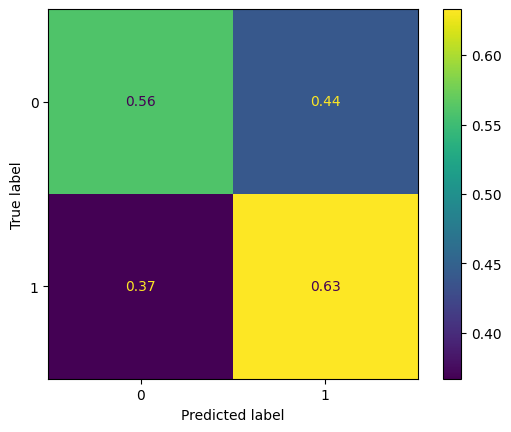

In [0]:
cm = confusion_matrix(y_test, pred4, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [0]:
acccuracySinBalanceo = accuracy_score(y_test,pred4)
print('Accuracy test = '+str(acccuracySinBalanceo))

Accuracy test = 0.5602371730778718


In [0]:
AcucuracyBalanceado = balanced_accuracy_score(y_test, pred4)
print('Balanced Accuracy test búsqueda = '+str(AcucuracyBalanceado))

Balanced Accuracy test búsqueda = 0.5965686749596355


In [0]:
print(classification_report(y_test, pred4))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72    828659
           1       0.00      0.63      0.01      2464

    accuracy                           0.56    831123
   macro avg       0.50      0.60      0.36    831123
weighted avg       1.00      0.56      0.72    831123

